In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../core")
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev, UnivariateSpline
from settings import *
from tools import get_mids

In [3]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)

315567360.0
2.28
1.44e-18


### local coordinates

In [4]:
coords = {
    'IceCube': {"lon": 0*u.deg, "lat": -90*u.deg},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg}
}

## Get background flux
this is calculated in core/atmospheric_background.py

In [5]:
# MCEQ atmospheric background
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)

# Get aeff
this is calculated in core/aeff_calculations.py, but we show here the results step by step

In [6]:
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d = pickle.load(f)

with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_2d_full = pickle.load(f)

log_emids = get_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


## effective area checking plots

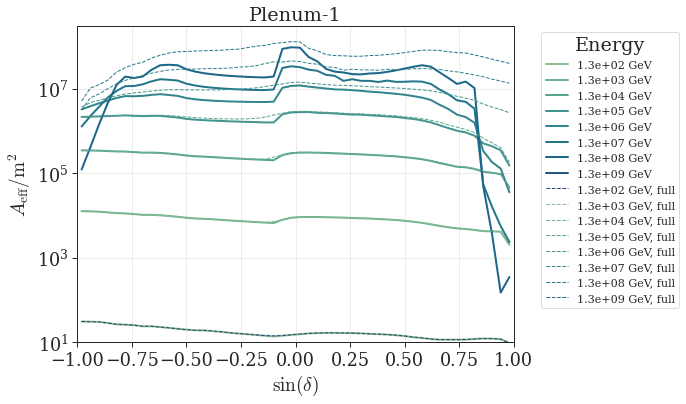

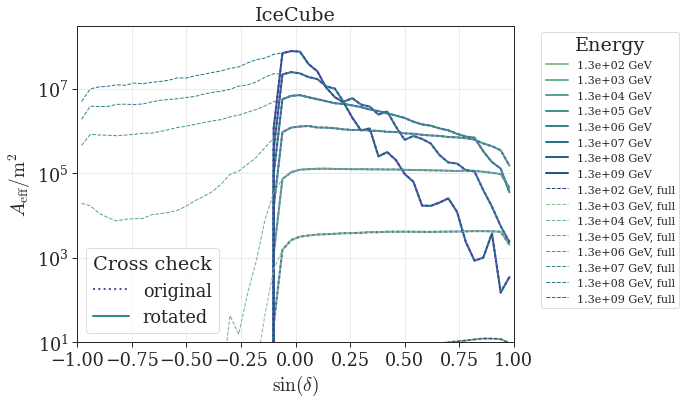

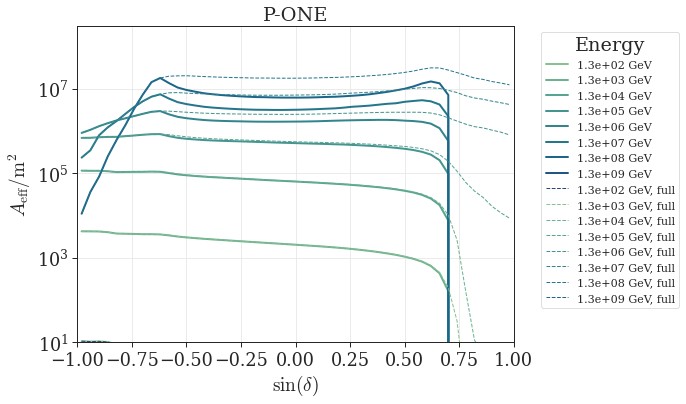

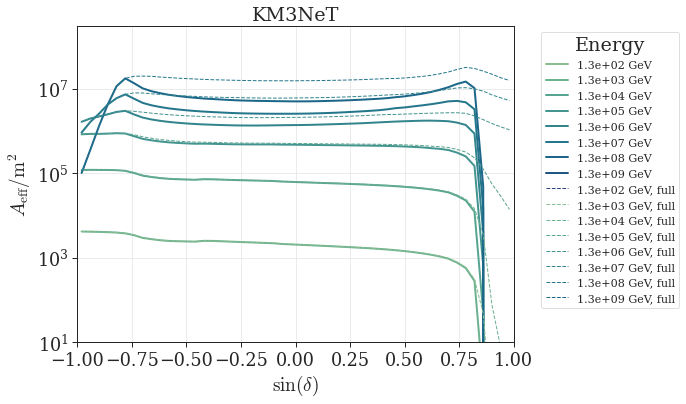

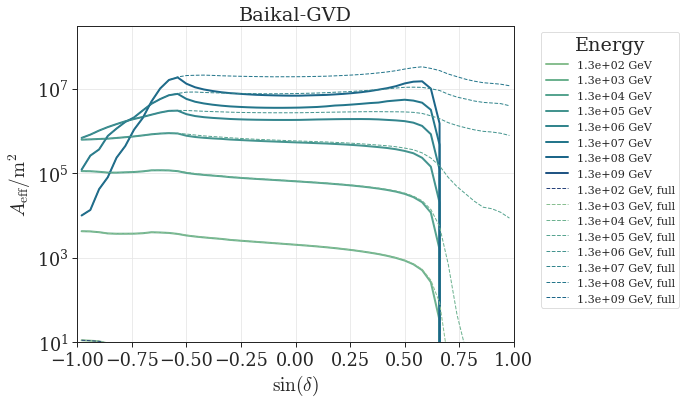

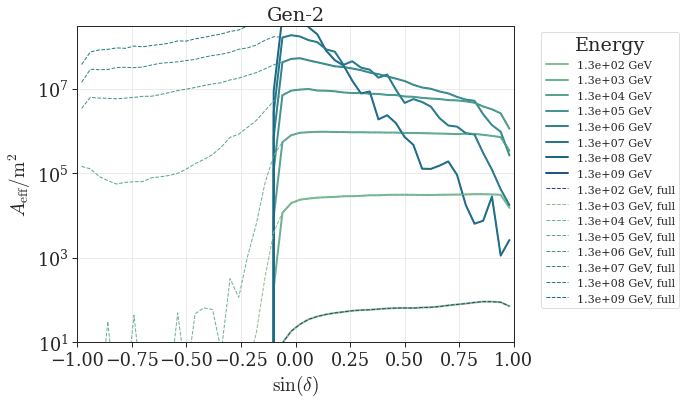

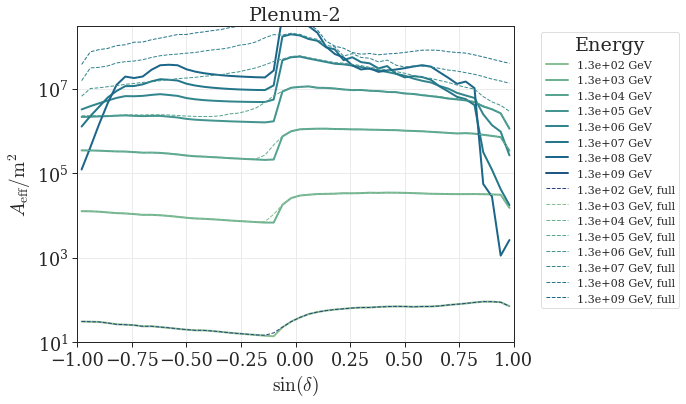

In [7]:
factor = 5
nlines = len(emids) // factor + 1
reset_palette(nlines)
mid_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][nlines // 2]
for k in aeff_2d:
    plt.figure(figsize=(10, 6))
    for ie, ae in enumerate(aeff_2d[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-", # rotated
            lw=2
        )
        if k=="IceCube":
            plt.plot(
                sindec_mids, aeff_2d["IceCube"][ie*factor],
                ls=":", # original
                color=slightly_change_color(line[0].get_color(), amount=0.2),
                lw=2
            )
    for ie, ae in enumerate(aeff_2d_full[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV, full",
            ls="--", # rotated
            lw=1
        )
    plt.yscale("log")
    plt.title(k)
    if k=="IceCube":
        lines = [
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=slightly_change_color(mid_color),
                linestyle=":"
            ),
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=mid_color,
                linestyle="-")
        ]
        labels = ['original', 'rotated']
        lg = plt.legend(lines, labels, title="Cross check")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy", fontsize="xx-small")
    if k=="IceCube":
        ax = plt.gca()
        ax.add_artist(lg)                
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 3E8)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
    plt.savefig(f"../plots/{k}_alt_aeff.pdf")


# 1D slices in declination

[ 6 13 21 25 29 37 44]


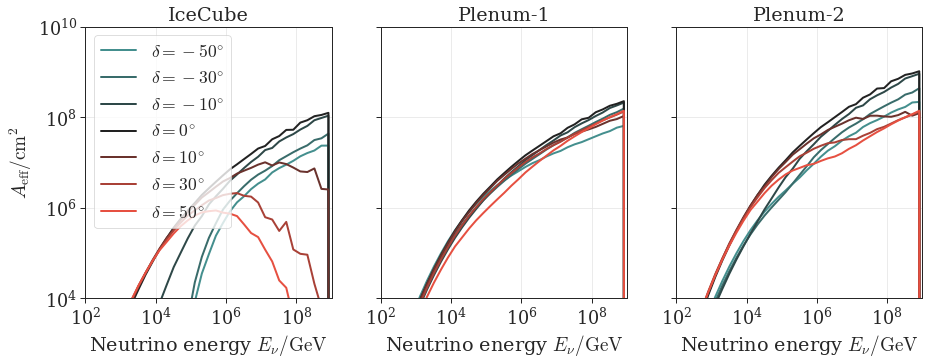

In [8]:
ref_decs = np.array([-50, -30, -10, 0, 10, 30, 50])
inds = np.array([np.argmin(np.abs(sindec_bins - np.sin(np.deg2rad(rd)))) for rd in ref_decs])
print(inds)
sns.set_palette(sns.diverging_palette(190, 15, l=55, sep=2, center="dark", n=len(ref_decs)))

fig, axes=plt.subplots(ncols=3, figsize=(15,5), sharey=True)

for ai, names in enumerate(["IceCube", "Plenum-1", "Plenum-2"]):
    ax = axes[ai]
    ax.set_title(names)
    for ii, ind in enumerate(inds):
        ax.plot(
            emids, aeff_2d_full[names][:,ind], 
            label=r"$\delta = {}^{{\circ}}$".format(ref_decs[ii]),
            #color=many_colors[ii]
        )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1E4, 1E10)
    ax.set_xlim(1E2, 1E9)
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
    if ai==0: 
        ax.legend(loc=2)
        ax.set_ylabel(r'$A_{\rm eff} / \rm cm^2$')

## 1D averaged slices

### p-one from paper

In [144]:
location = "../resources/"
msq2cmsq = 1E4

try:
    A_55 = np.loadtxt(location + "A_55.csv", delimiter = ",")
    A_15 = np.loadtxt(location + "A_15.csv", delimiter = ",")
    A_51 = np.loadtxt(location + "A_51.csv", delimiter = ",")
except:
    ValueError('Could not find the effective areas! Check the location')
    
A_55 = A_55[A_55[:,0].argsort()]
A_15 = A_15[A_15[:,0].argsort()]
A_51 = A_51[A_51[:,0].argsort()]
A_55 = np.concatenate((np.array([[100, 0]]), A_55), axis=0)
A_15 = np.concatenate((np.array([[100, 0]]), A_15), axis=0)
A_51 = np.concatenate((np.array([[100, 0]]), A_51), axis=0)

spl_A_15 = UnivariateSpline(A_15[:,0], A_15[:,1], k=1, s=0, ext=3) # * msq2cmsq
spl_A_51 = UnivariateSpline(A_51[:,0], A_51[:,1], k=1, s=0, ext=3) # * msq2cmsq
spl_A_55 = UnivariateSpline(A_55[:,0], A_55[:,1], k=1, s=0, ext=3) # * msq2cmsq

E_bins = ebins[ebins<=1E7]
E_mids = get_mids(E_bins)
E_width = np.diff(E_bins)

aeff_p1 = np.array([spl_A_15(E_mids), spl_A_55(E_mids), spl_A_51(E_mids)]).T * msq2cmsq

Text(0.5, 1.0, 'P-ONE from paper')

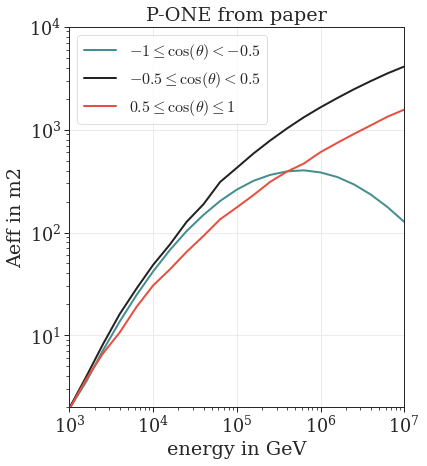

In [72]:
sns.set_palette(sns.diverging_palette(190, 15, l=55, sep=2, center="dark", n=3))
f, ax = plt.subplots(figsize=(6, 7))

ax.plot(E_bins, spl_A_15(E_bins), label=r"$-1 \leq \cos (\theta) < -0.5$")
ax.plot(E_bins, spl_A_55(E_bins), label=r"$-0.5 \leq \cos (\theta) < 0.5$")
ax.plot(E_bins, spl_A_51(E_bins), label=r"$0.5 \leq \cos (\theta) \leq 1$")
ax.set_xlim(1E3, 1E7)
ax.set_ylim(2, 1E4)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize="small")
ax.grid(True)
ax.set_ylabel("Aeff in m2")
ax.set_xlabel("energy in GeV")
ax.set_title("P-ONE from paper")

In [73]:
from matplotlib.lines import Line2D

In [74]:
cz, aic, ap1 = np.loadtxt("../resources/HUT.txt")
spl_a_ratio = UnivariateSpline(cz, ap1/aic, k=1, s=0)

[ 0 13 37 50]


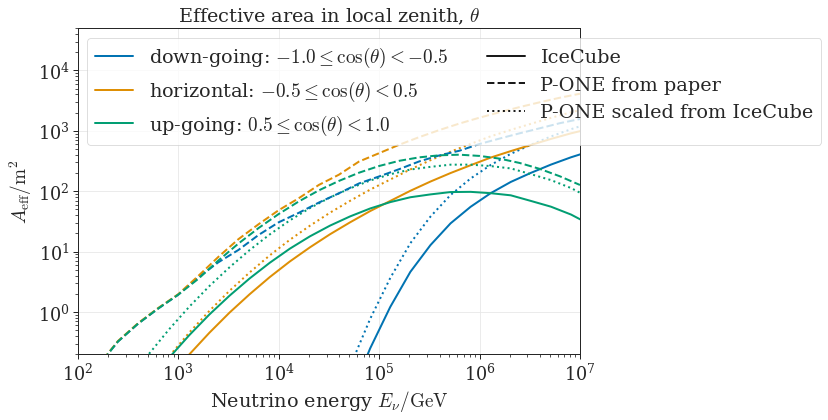

In [75]:
sns.set_palette("colorblind", n_colors=3)
ref_sdecs = np.array([-1, -0.5, 0.5, 1])
zenith_names = ["down-going", "horizontal", "up-going"]
inds = np.array([np.argmin(np.abs(sindec_bins - rd)) for rd in ref_sdecs])
print(inds)

fig, ax = plt.subplots(figsize=(9,6))
names = "IceCube"
ax.set_title(r"Effective area in local zenith, $\theta$")
for ii, ind in enumerate(inds[:-1]):
    p = ax.plot(
        emids, 
        np.sum((aeff_2d_full[names] * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) *1E-4, 
        label=r"{}: ${} \leq \cos (\theta) < {}$".format(zenith_names[ii], ref_sdecs[ii], ref_sdecs[ii+1]),
    )
    ax.plot(
        emids, 
        np.sum((aeff_2d_full[names] * spl_a_ratio(sindec_mids) * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) *1E-4, 
        ls=":", color=p[0].get_color()
    )
### aeff of P-ONE from paper
ax.plot(E_bins, spl_A_51(E_bins), ls="--")
ax.plot(E_bins, spl_A_55(E_bins), ls="--")
ax.plot(E_bins, spl_A_15(E_bins), ls="--")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(2E-1, 5E4)
ax.set_xlim(1E2, 1E7)
ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
ax.set_ylabel(r'$A_{\rm eff} / \rm m^2$')

handles, labels = ax.get_legend_handles_labels()

handles.extend(
    [matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="-",
        lw=2, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="--",
        lw=2, label="P-ONE from paper"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls=":",
        lw=2, label="P-ONE scaled from IceCube")
    ]
)
ax.legend(handles=handles, loc=2, ncol=2, fontsize="medium")

[ 0 13 37 50]


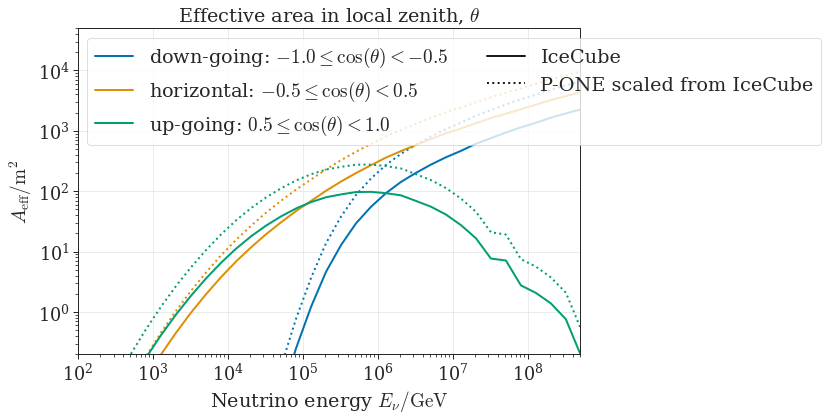

In [76]:
sns.set_palette("colorblind", n_colors=3)
ref_sdecs = np.array([-1, -0.5, 0.5, 1])
zenith_names = ["down-going", "horizontal", "up-going"]
inds = np.array([np.argmin(np.abs(sindec_bins - rd)) for rd in ref_sdecs])
print(inds)

fig, ax = plt.subplots(figsize=(9,6))
names = "IceCube"
ax.set_title(r"Effective area in local zenith, $\theta$")
for ii, ind in enumerate(inds[:-1]):
    p = ax.plot(
        emids, 
        np.sum((aeff_2d_full[names] * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) *1E-4, 
        label=r"{}: ${} \leq \cos (\theta) < {}$".format(zenith_names[ii], ref_sdecs[ii], ref_sdecs[ii+1]),
    )
    ax.plot(
        emids, 
        np.sum((aeff_2d_full[names] * spl_a_ratio(sindec_mids) * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) *1E-4, 
        ls=":", color=p[0].get_color()
    )
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim(2E-1, 5E4)
ax.set_xlim(1E2, 5E8)
ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
ax.set_ylabel(r'$A_{\rm eff} / \rm m^2$')

handles, labels = ax.get_legend_handles_labels()

handles.extend(
    [matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="-",
        lw=2, label="IceCube"),
    #matplotlib.lines.Line2D(
    #    range(1), range(1), 
    #    color="k", ls="--",
    #    lw=2, label="P-ONE from paper"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls=":",
        lw=2, label="P-ONE scaled from IceCube")
    ]
)
ax.legend(handles=handles, loc=2, ncol=2, fontsize="medium")

[ 0 12 37 49]


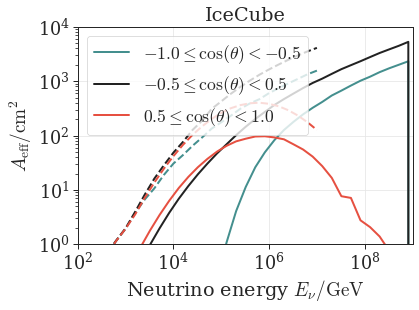

In [77]:
sns.set_palette(sns.diverging_palette(190, 15, l=55, sep=2, center="dark", n=3))
ref_sdecs = np.array([-1, -0.5, 0.5, 1])
inds = np.array([np.argmin(np.abs(sindec_mids - rd)) for rd in ref_sdecs])
print(inds)

fig, ax = plt.subplots()

for ai, names in enumerate(["IceCube"]):
    ax.set_title(names)
    for ii, ind in enumerate(inds[:-1]):
        ax.plot(
            emids, 
            np.sum((aeff_2d_full[names] * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) *1E-4, 
            label=r"${} \leq \cos (\theta) < {}$".format(ref_sdecs[ii], ref_sdecs[ii+1]),
        )
    if names=="IceCube":
        ### aeff NOT normalized by solid angle
        ax.plot(E_bins, spl_A_51(E_bins), ls="--")
        ax.plot(E_bins, spl_A_55(E_bins), ls="--")
        ax.plot(E_bins, spl_A_15(E_bins), ls="--")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1, 1E4)
    ax.set_xlim(1E2, 1E9)
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
    if ai==0: 
        ax.legend(loc=2)
        ax.set_ylabel(r'$A_{\rm eff} / \rm cm^2$')

[ 0 12 37 49]


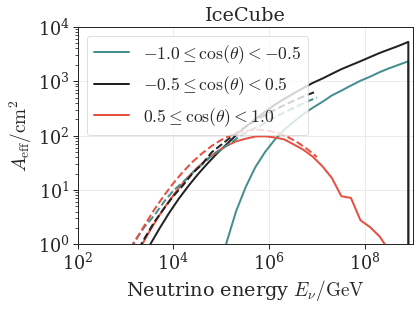

In [78]:
sns.set_palette(sns.diverging_palette(190, 15, l=55, sep=2, center="dark", n=3))
ref_sdecs = np.array([-1, -0.5, 0.5, 1])
inds = np.array([np.argmin(np.abs(sindec_mids - rd)) for rd in ref_sdecs])
print(inds)

fig, ax = plt.subplots()

for ai, names in enumerate(["IceCube"]):
    ax.set_title(names)
    for ii, ind in enumerate(inds[:-1]):
        ax.plot(
            emids, 
            np.sum((aeff_2d_full[names] * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) *1E-4, 
            label=r"${} \leq \cos (\theta) < {}$".format(ref_sdecs[ii], ref_sdecs[ii+1]),
        )
    if names=="IceCube":
        ### aeff NOT normalized by solid angle
        ax.plot(E_bins, spl_A_51(E_bins) / np.pi, ls="--")
        ax.plot(E_bins, spl_A_55(E_bins) / np.pi / 2, ls="--")
        ax.plot(E_bins, spl_A_15(E_bins) / np.pi, ls="--")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1, 1E4)
    ax.set_xlim(1E2, 1E9)
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
    if ai==0: 
        ax.legend(loc=2)
        ax.set_ylabel(r'$A_{\rm eff} / \rm cm^2$')

[ 0 12 22 37 49]


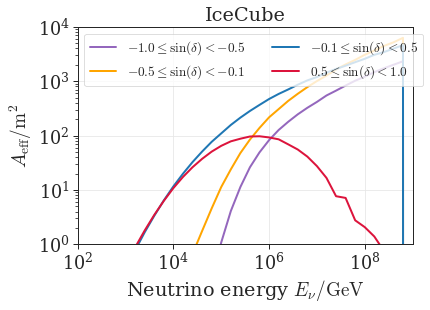

In [79]:
## compare to https://arxiv.org/pdf/1609.04981.pdf fig 1
sns.set_palette(["tab:purple", "orange", "tab:blue", "crimson"])
ref_sdecs = np.sin(np.deg2rad(np.array([-90, -30, -5, 30, 90])))
inds = np.array([np.argmin(np.abs(sindec_mids - rd)) for rd in ref_sdecs])
print(inds)

fig, axes = plt.subplots()
for ai, names in enumerate(["IceCube"]):
    ax = axes
    ax.set_title(names)
    for ii, ind in enumerate(inds[:-1]):
        ax.plot(
            ebins[:-1], 
            np.sum((aeff_2d_full[names] * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]) * 1E-4 , 
            label=r"${:1.1f} \leq \sin (\delta) < {:1.1f}$".format(ref_sdecs[ii], ref_sdecs[ii+1]),
        )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim(1, 1E4)
    ax.set_xlim(1E2, 1E9)
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
    if ai==0: 
        ax.legend(loc=2, fontsize="x-small", ncol=2)
        ax.set_ylabel(r'$A_{\rm eff} / \rm m^2$')

## 2D plots

In [80]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("mako", n_colors=16))
from aeff_calculations import aeff_eval_e_sd

In [81]:
### low res plot for IC
ref_sdecs = np.array([-1, -0.5, 0.5, 1])
inds = np.array([np.argmin(np.abs(sindec_bins - rd)) for rd in ref_sdecs])
print("index slices", inds)
aeff_new_ic = []
for ii, ind in enumerate(inds[:-1]):
    aeff_new_ic.append(np.sum((aeff_2d_full["IceCube"] * sindec_width)[:,ind:inds[ii+1]], axis=-1) / (ref_sdecs[ii+1] - ref_sdecs[ii]))
aeff_new_ic = np.array(aeff_new_ic).T

index slices [ 0 13 37 50]


In [145]:
print(np.sum(aeff_eval_e_sd(aeff_2d_full["IceCube"], sindec_width, ewidth, ra_width) * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO * LIVETIME))

new_sindec_width = np.diff(ref_sdecs)
n_ic = np.sum(aeff_eval_e_sd(aeff_new_ic, new_sindec_width, ewidth, ra_width) * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO * LIVETIME)
n_p1 = np.sum(aeff_eval_e_sd(aeff_p1, new_sindec_width, E_width, [np.pi * 2]) * (E_mids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO * LIVETIME)
## select above 10 TeV
emask = E_mids > 1E4
n_p1_m = np.sum(aeff_eval_e_sd(aeff_p1[emask], new_sindec_width, E_width[emask], [np.pi * 2]) * (E_mids[emask]/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO * LIVETIME)
print("IC:", n_ic)
print("P1:", n_p1)
print("ratio p/i:", n_p1/n_ic)
print("P1 masked:", n_p1_m)
print("ratio pm/i:", n_p1_m/n_ic)


2440.9415315212723
IC: 2440.9415315212714
P1: 28344.155508049324
ratio p/i: 11.611976420584051
P1 masked: 9502.660725044681
ratio pm/i: 3.8930308662994992


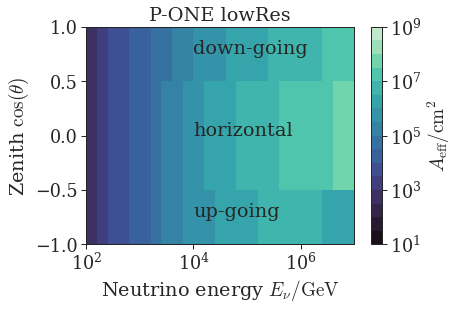

In [146]:
ref_sdecs = np.array([-1, -0.5, 0.5, 1])
fig, ax = plt.subplots()
ax.set_title('P-ONE lowRes')
p = ax.pcolormesh(
    E_bins,
    ref_sdecs, 
    aeff_p1.T,
    norm=LogNorm(),
    vmin=1E1,
    vmax=1E9,
    cmap=cmap
)
ax.text(1E4, -0.75, "up-going")
ax.text(1E4, 0, "horizontal")
ax.text(1E4, +0.75, "down-going")
ax.set_xscale("log")
ax.set_xlim(1E2, 1E7)
ax.set_ylabel(r'Zenith $\cos(\theta)$')
ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
cb = fig.colorbar(p)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')

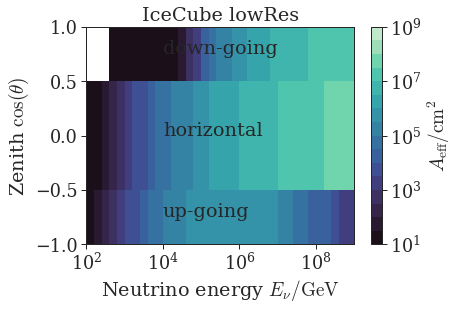

In [147]:
fig, ax = plt.subplots()
ax.set_title('IceCube lowRes')
p = ax.pcolormesh(
    ebins,
    ref_sdecs, 
    aeff_new_ic.T[::-1], ## reverse sin(d) -> cos(z)
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.text(1E4, -0.75, "up-going")
ax.text(1E4, 0, "horizontal")
ax.text(1E4, +0.75, "down-going")
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Zenith $\cos(\theta)$')
ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
cb = fig.colorbar(p)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')

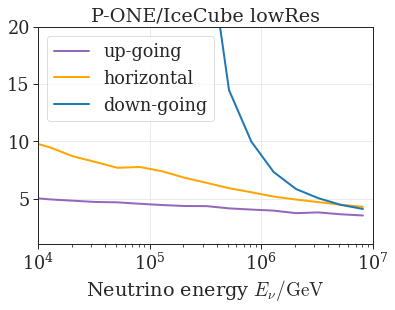

In [165]:
## ratio plot
fig, ax = plt.subplots()
ax.set_title('P-ONE/IceCube lowRes')
p = ax.plot(
    E_mids,
    aeff_p1 / aeff_new_ic[:len(aeff_p1), ::-1],
    label=["up-going", "horizontal", "down-going"]
)
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(1E4, 1E7)
ax.set_ylim(1, 20)
ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
ax.legend()

### scale IceCube aeff to P-ONE paper claim
* only upgoing 5deg above horizon
* energy threshold 10 TeV

#### full aeff

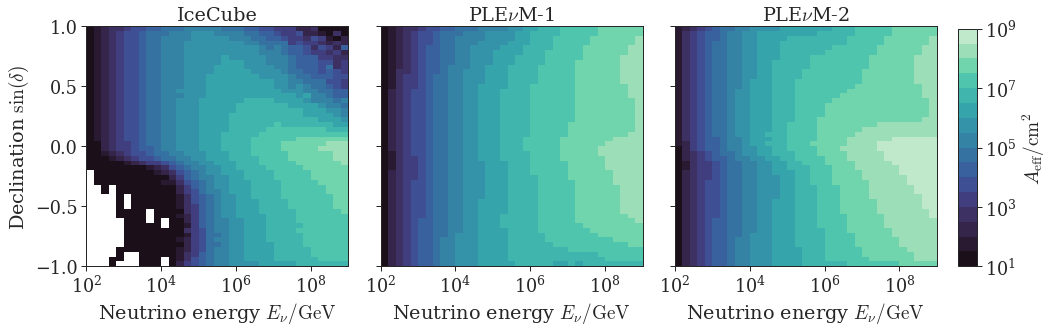

In [11]:
fig, axes=plt.subplots(ncols=3, figsize=(15,5), sharey=True)
ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_2d_full['IceCube'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')

ax = axes[1]
ax.set_title(r'PLE$\nu$M-1')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_2d_full['Plenum-1'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)

ax = axes[2]
ax.set_title(r'PLE$\nu$M-2')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_2d_full['Plenum-2'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)

for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66]) 
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
fig.subplots_adjust(right=0.88)
fig.savefig("../plots/aeff_comparison_IC_PLENUM-1-2.pdf")

# Smearing matrix

# energy kde

In [12]:
with open("../resources/energy_smearing_kde.pckl", "rb") as f:
    kvals = pickle.load(f)
# normalize per bin in true energy
normed_kvals = kvals/np.sum(kvals, axis=0)

eri = get_mids(np.arange(0.5, 9, 0.2))
# log_emids are the same as for effective area binning
ee, rr = np.meshgrid(log_emids, eri)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

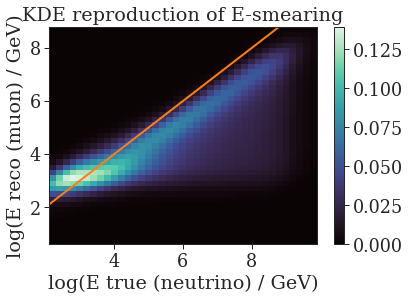

In [13]:
plt.pcolormesh(
    ee,
    rr,
    kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

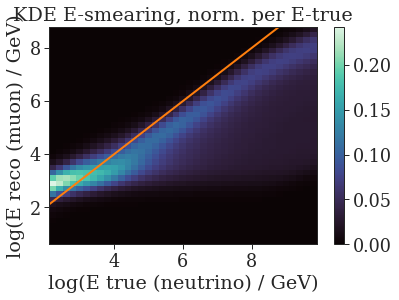

In [14]:
normed_kvals = kvals/np.sum(kvals, axis=0)
plt.pcolormesh(
    ee,
    rr,
    normed_kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE E-smearing, norm. per E-true")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

### show aeff in true energy and reco energy

Text(0, 0.5, '$\\sin(\\delta)$')

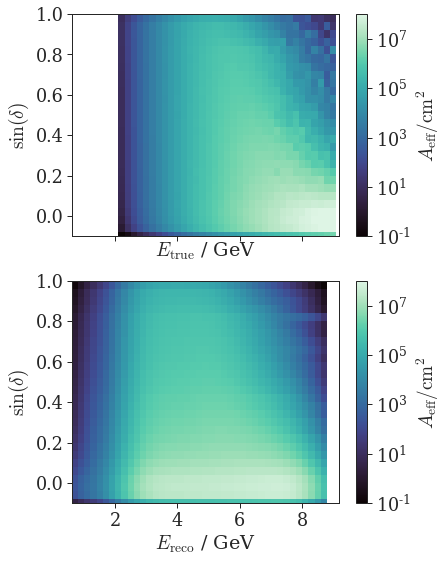

In [15]:
label = "10yr IceCube"

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,9))
im = ax1.pcolormesh(
    log_emids,
    sindec_bins,
    aeff_2d["IceCube"].T,
    norm=LogNorm(),
    vmin=0.1,
    vmax=1E8
)
plt.colorbar(im, ax=ax1, label=r"$A_{\rm eff} / \rm cm^2$")
ax1.set_ylim(-0.1, 1)
ax1.set_xlim(np.min(eri), 9.2)
ax1.set_xlabel(r"$E_{\rm true}$ / GeV")
ax1.set_ylabel(r"$\sin(\delta)$")
im = ax2.pcolormesh(
    eri,
    sindec_bins,
    np.dot(normed_kvals, aeff_2d["IceCube"]).T,
    norm=LogNorm(),
    vmin=0.1,
    vmax=1E8
)
plt.colorbar(im, ax=ax2, label=r"$A_{\rm eff} / \rm cm^2$")
ax2.set_ylim(-0.1, 1)
ax2.set_xlim(np.min(eri), 9.2)
ax2.set_xlabel(r"$E_{\rm reco}$ / GeV")
ax2.set_ylabel(r"$\sin(\delta)$")

# Plot some slices of this smearing matrix

In [16]:
public_data_hist = np.genfromtxt(
    "../icecube_10year_ps/irfs/IC86_II_smearing.csv",
    skip_header=1
)
# #   0                    1                    2                  3                4                 5 
# #  log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min[deg]  Dec_nu_max[deg]  log10(E/GeV)_min  log10(E/GeV)_max
# #   6                7            8               9                 10
# #  PSF_min[deg]  PSF_max[deg]  AngErr_min[deg]  AngErr_max[deg]  Fractional_Counts

In [17]:
log_sm_emin, log_sm_emax = public_data_hist[:,0], public_data_hist[:,1]
log_sm_emids = (log_sm_emin + log_sm_emax) / 2.

sm_dec_min, sm_dec_max = public_data_hist[:,2], public_data_hist[:,3]
sm_dec_mids = (sm_dec_min + sm_dec_max) / 2.

log_sm_ereco_min, log_sm_ereco_max = public_data_hist[:,4], public_data_hist[:,5]
log_sm_ereco_mids = (log_sm_ereco_min + log_sm_ereco_max) / 2.

log_psf_min, log_psf_max = np.log10(public_data_hist[:,6]), np.log10(public_data_hist[:,7])
log_psf_mids = (log_psf_min + log_psf_max) / 2.

log_sigma_min, log_sigma_max = np.log10(public_data_hist[:,8]), np.log10(public_data_hist[:,9])
log_sigma_mids = (log_sigma_min + log_sigma_max) / 2.

fractional_event_counts = public_data_hist[:,10]

dec_binning = np.unique(np.concatenate([sm_dec_min, sm_dec_max]))
log_psf_binning = np.linspace(-4.5, 2.5, 25)
ebinning = np.arange(0.5, 9, 0.5)
log_sigma_binning = np.linspace(-0.7, 1.2, 26)

### point spread function $\Psi = | \vec{\Omega}_{\rm true} - \vec{\Omega}_{\rm reco} |$

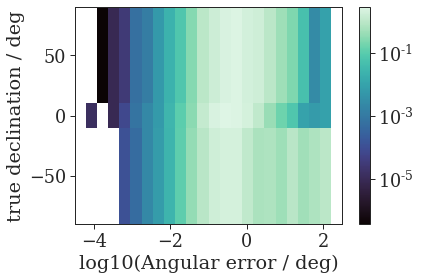

In [18]:
## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    sm_dec_mids,
    (log_psf_binning, dec_binning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.ylabel("true declination / deg")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

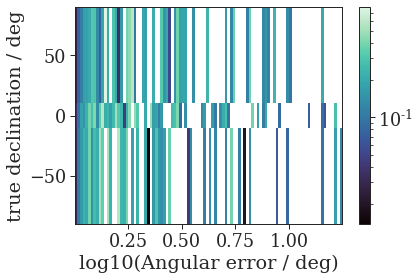

In [19]:
## visualization
# original binning
mask = log_psf_mids < 0.1
h, _, _, _ = plt.hist2d(
    np.power(10, log_psf_mids[mask]),
    sm_dec_mids[mask],
    bins=(100, dec_binning),
    weights = fractional_event_counts[mask],
    norm=LogNorm()
)
plt.ylabel("true declination / deg")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

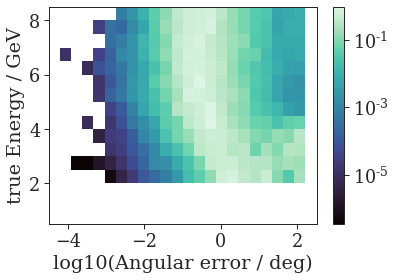

In [20]:
## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    log_sm_emids,
    (log_psf_binning, ebinning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.ylabel("true Energy / GeV")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

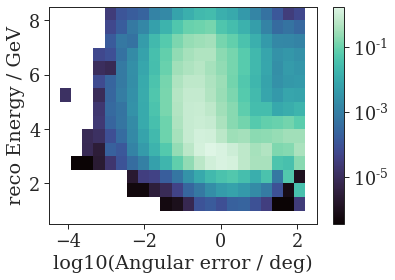

In [21]:
## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    log_sm_ereco_mids,
    (log_psf_binning, ebinning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.ylabel("reco Energy / GeV")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

### angular reco error estimator (sigma)

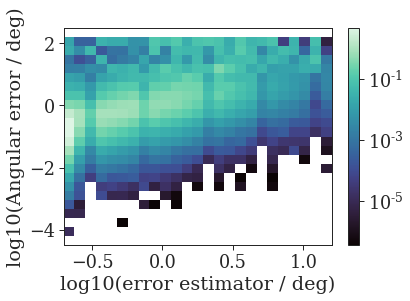

In [22]:
h, _, _, _ = plt.hist2d(
    log_sigma_mids,
    log_psf_mids,
    (log_sigma_binning, log_psf_binning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.xlabel("log10(error estimator / deg)")
plt.ylabel("log10(Angular error / deg)")
plt.colorbar()

### energy

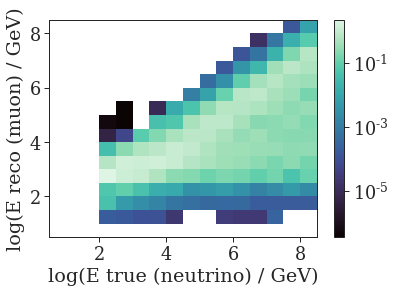

In [23]:
## visualization
# original binning
_ = plt.hist2d(
    log_sm_emids,
    log_sm_ereco_mids,
    ebinning,
    weights = fractional_event_counts,
    norm = LogNorm()
)
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")
plt.colorbar()

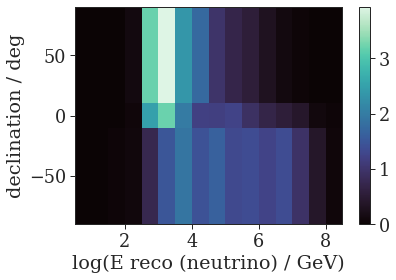

In [24]:
## visualization
# original binning
_ = plt.hist2d(
    log_sm_ereco_mids,
    sm_dec_mids,
    (ebinning, dec_binning),
    weights = fractional_event_counts,
)
plt.ylabel("declination / deg")
plt.xlabel("log(E reco (neutrino) / GeV)")
plt.colorbar()

## apply PSF smearing -- WIP
needed for spatial diffuse flux analyses in future

In [25]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

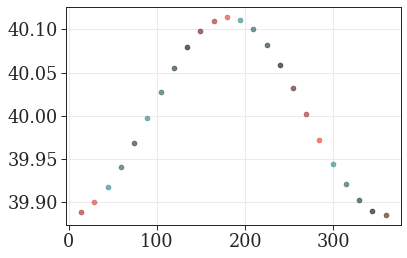

In [26]:
time = Time('2021-6-21 00:00:00', scale="utc")
plt.figure()
for i in range(24):
    loc = EarthLocation(
        lat=50,
        lon=(0 + i * 360/24) % 360
    )
    a = SkyCoord(0, 0, unit="radian", frame=AltAz(obstime=time, location=loc))
    plt.scatter(a.icrs.ra, a.icrs.dec, alpha=0.7)